<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="6" color="black"><b>  Object Detection using Faster-RCNN (TFv2) in ART and Patch Attack  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate how to use TensorFlow v2 Faster-RCNN object detection with ART.


## Contents

1.	Installation prerequisits
2.  Setting up TensorFlowV2FasterRCNN
3.  Detecting objects and drawing bounding boxes
4.  Attacking with an Adversarial Patch

## 1. Installation prerequisits

In order to use TensorFlowV2FasterRCNN, the [TensorFlow 2 Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/index.html) must be installed. The official installation documentation can be found [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html).

Additionally, the following tutotials/hints are useful, particularly if using an Apple device witih the M1 chip:
- [If issues installing tensorflow-text](https://developer.apple.com/forums/thread/688336#:~:text=I%20got%20the%20TensorFlow%20object%20detection%20tutorial%20page)
- [Other issues installing tensorflow-text](https://developer.apple.com/forums/thread/700906#:~:text=pip%20install%20/Downloads/tensorflow_text%2D2.8.1%2Dcp38%2Dcp38%2Dmacosx_11_0_arm64.whl)
- [If issues installing tensorflow-io](https://github.com/tensorflow/io/issues/1625#:~:text=Putting%20this%20here%20in%20case%20anybody%20else%20runs%20into%20the%20same%20issue%20I%20had%20with%20using%20conda.%0AI%20finally%20got%20this%20working%20by%20ignoring%20the%20instructions%20here.%20And%20doing%20the%20following%3A)


The general steps involved (follow the tutorials for full instruction) once you have created a new virtual (e.g. anaconda) environment:
1. ```brew install protobuf```
2. ```pip install cython```
3. ```pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI```
4. ```mkdir TensorFlow.. cd TensorFlow.. git clone git@github.com:tensorflow/models.git```
5. ```cd models/research.. protoc object_detection/protos/*.proto --python_out=.```
6. ```cp object_detection/packages/tf2/setup.py .```
7. ```git clone https://github.com/tensorflow/io.git```
8. ```cd io.. python setup.py -q bdist_wheel --project tensorflow_io_gcs_filesystem```
9. ```pip install --no-deps dist/tensorflow_io_gcs_filesystem-0.26.0-cp39-cp39-macosx_12_0_arm64.whl```
10. ```python setup.py -q bdist_wheel```
11. ```pip install --no-deps dist/tensorflow_io-0.27.0-cp39-cp39-macosx_11_0_arm64.whl ```
12. ```cd models/research.. pip install --no-deps tf-models-official```
13. ```python -m pip install --force --no-dependencies .```
14. ```pip install protobuf==3.20```
15. ```pip install tf_slim```

## 2. Setting up TensorFlowV2FasterRCNN

In [22]:
from art.estimators.object_detection.tensorflow_v2_faster_rcnn import TensorFlowV2FasterRCNN
from art.utils import load_dataset
import tensorflow as tf
import numpy as np
import pandas as pd

import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
from pathlib import Path
from PIL import Image
import requests
from io import BytesIO

from object_detection.utils import label_map_util

import cv2
import matplotlib
import matplotlib.pyplot as plt
import os

from art.attacks.evasion import RobustDPatch

# COCO categories
categories = [{'id': 1, 'name': 'person'},
 {'id': 2, 'name': 'bicycle'},
 {'id': 3, 'name': 'car'},
 {'id': 4, 'name': 'motorcycle'},
 {'id': 5, 'name': 'airplane'},
 {'id': 6, 'name': 'bus'},
 {'id': 7, 'name': 'train'},
 {'id': 8, 'name': 'truck'},
 {'id': 9, 'name': 'boat'},
 {'id': 10, 'name': 'traffic light'},
 {'id': 11, 'name': 'fire hydrant'},
 {'id': 13, 'name': 'stop sign'},
 {'id': 14, 'name': 'parking meter'},
 {'id': 15, 'name': 'bench'},
 {'id': 16, 'name': 'bird'},
 {'id': 17, 'name': 'cat'},
 {'id': 18, 'name': 'dog'},
 {'id': 19, 'name': 'horse'},
 {'id': 20, 'name': 'sheep'},
 {'id': 21, 'name': 'cow'},
 {'id': 22, 'name': 'elephant'},
 {'id': 23, 'name': 'bear'},
 {'id': 24, 'name': 'zebra'},
 {'id': 25, 'name': 'giraffe'},
 {'id': 27, 'name': 'backpack'},
 {'id': 28, 'name': 'umbrella'},
 {'id': 31, 'name': 'handbag'},
 {'id': 32, 'name': 'tie'},
 {'id': 33, 'name': 'suitcase'},
 {'id': 34, 'name': 'frisbee'},
 {'id': 35, 'name': 'skis'},
 {'id': 36, 'name': 'snowboard'},
 {'id': 37, 'name': 'sports ball'},
 {'id': 38, 'name': 'kite'},
 {'id': 39, 'name': 'baseball bat'},
 {'id': 40, 'name': 'baseball glove'},
 {'id': 41, 'name': 'skateboard'},
 {'id': 42, 'name': 'surfboard'},
 {'id': 43, 'name': 'tennis racket'},
 {'id': 44, 'name': 'bottle'},
 {'id': 46, 'name': 'wine glass'},
 {'id': 47, 'name': 'cup'},
 {'id': 48, 'name': 'fork'},
 {'id': 49, 'name': 'knife'},
 {'id': 50, 'name': 'spoon'},
 {'id': 51, 'name': 'bowl'},
 {'id': 52, 'name': 'banana'},
 {'id': 53, 'name': 'apple'},
 {'id': 54, 'name': 'sandwich'},
 {'id': 55, 'name': 'orange'},
 {'id': 56, 'name': 'broccoli'},
 {'id': 57, 'name': 'carrot'},
 {'id': 58, 'name': 'hot dog'},
 {'id': 59, 'name': 'pizza'},
 {'id': 60, 'name': 'donut'},
 {'id': 61, 'name': 'cake'},
 {'id': 62, 'name': 'chair'},
 {'id': 63, 'name': 'couch'},
 {'id': 64, 'name': 'potted plant'},
 {'id': 65, 'name': 'bed'},
 {'id': 67, 'name': 'dining table'},
 {'id': 70, 'name': 'toilet'},
 {'id': 72, 'name': 'tv'},
 {'id': 73, 'name': 'laptop'},
 {'id': 74, 'name': 'mouse'},
 {'id': 75, 'name': 'remote'},
 {'id': 76, 'name': 'keyboard'},
 {'id': 77, 'name': 'cell phone'},
 {'id': 78, 'name': 'microwave'},
 {'id': 79, 'name': 'oven'},
 {'id': 80, 'name': 'toaster'},
 {'id': 81, 'name': 'sink'},
 {'id': 82, 'name': 'refrigerator'},
 {'id': 84, 'name': 'book'},
 {'id': 85, 'name': 'clock'},
 {'id': 86, 'name': 'vase'},
 {'id': 87, 'name': 'scissors'},
 {'id': 88, 'name': 'teddy bear'},
 {'id': 89, 'name': 'hair drier'},
 {'id': 90, 'name': 'toothbrush'}]

#### Define helper functions to extract predictions and draw bounding boxes

In [3]:
def extract_predictions_standard(predictions_, conf_thresh):
    predictions_class = [category_index[i]['name'] for i in list(predictions_["labels"])]
    if len(predictions_class) < 1:
        return [], [], []
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    predictions_score = list(predictions_["scores"])

    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t
    else:
        return [], [], []
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

def plot_image_with_boxes_standard(img, boxes, pred_cls, title):
    text_size = 2
    text_th = 3
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def plot_image_with_boxes_non_standard(image, boxes, class_names, scores, labels, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  

  try:
    fpath = Path(matplotlib.get_data_path(), "fonts/ttf/cmr10.ttf")
    font = ImageFont.truetype(str(fpath), size=50)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(labels[class_names[i]],
                                     int(100 * scores[i]))
      
      color = colors[hash(labels[class_names[i]]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

#### Fetch images

In [4]:
response = requests.get('https://ultralytics.com/images/zidane.jpg')
img = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
image = np.stack([img], axis=0).astype(np.float32)

# used for targeted attack
response = requests.get('https://ultralytics.com/images/bus.jpg')
target_img = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
target_image = np.stack([target_img], axis=0).astype(np.float32)

#### Define the object detector

In [5]:
obj_detector = TensorFlowV2FasterRCNN(
    input_shape=(640, 640, 3),
    model=None,
    filename="faster_rcnn_resnet101_v1_640x640_coco17_tpu-8",
    url="http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz"
)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-12-15 13:58:48.723567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 13:58:48.723692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3. Detecting objects and drawing bounding boxes

#### Using TF format

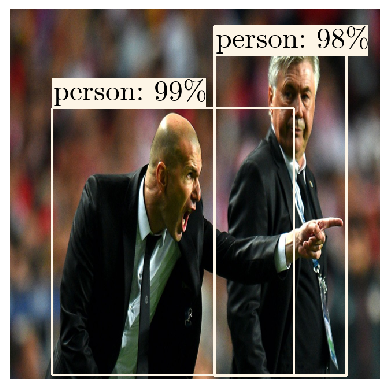

In [17]:
%matplotlib inline
dets = obj_detector.predict(image, standardise_output=False)
image_with_boxes = plot_image_with_boxes_non_standard(image[0].copy(),
                     dets[0]['boxes'], dets[0]['labels'], dets[0]['scores'], [i['name'] for i in categories], 5, 0.7)
plt.figure()
plt.axis("off")
plt.imshow(image_with_boxes.astype(np.uint8), interpolation="nearest")
plt.show()

#### Using standard pytorch output

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.


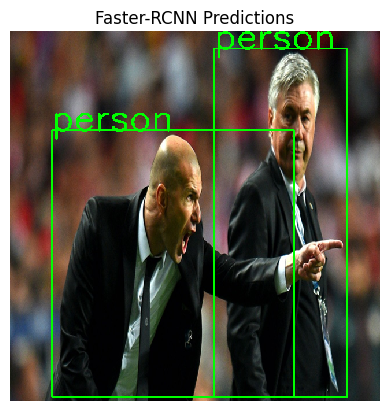

In [6]:
%matplotlib inline
dets = obj_detector.predict(image, standardise_output=True)
threshold = 0.8
preds = extract_predictions_standard(dets[0], threshold)
plot_image_with_boxes_standard(img=image[0].astype(np.uint8), boxes=preds[1], pred_cls=preds[0], title="Faster-RCNN Predictions")

## 4.  Attacking with an Adversarial Patch

#### Define a patch attack (here using targeted RobustDPatch)

In [13]:
attack = RobustDPatch(
    obj_detector,
    patch_shape=(300, 300, 3),
    patch_location=(50, 50),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=100,
    batch_size=1,
    verbose=True,
    targeted=True
)

#### Get predictions from the target image, generate a patch and apply it

In [14]:
y_target = obj_detector.predict(target_image)

patch = attack.generate(x=image, y=y_target)
patched_image = attack.apply_patch(image)

RobustDPatch iteration:   0%|          | 0/100 [00:00<?, ?it/s]

#### Get predictions for the patched image and draw bounding boxes (TF format)

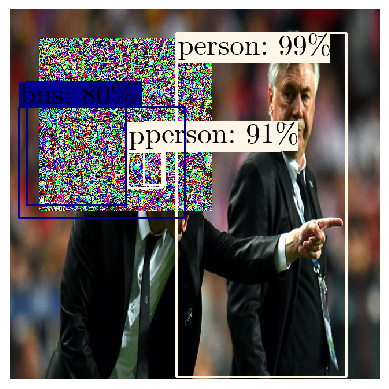

In [19]:
%matplotlib inline
dets = obj_detector.predict(patched_image, standardise_output=False)
image_with_boxes = plot_image_with_boxes_non_standard(patched_image[0].copy(),
                     dets[0]['boxes'], dets[0]['labels'], dets[0]['scores'], [i['name'] for i in categories], 5, 0.7)
plt.figure()
plt.axis("off")
plt.imshow(image_with_boxes.astype(np.uint8), interpolation="nearest")
plt.show()

#### Get predictions for the patched image and draw bounding boxes

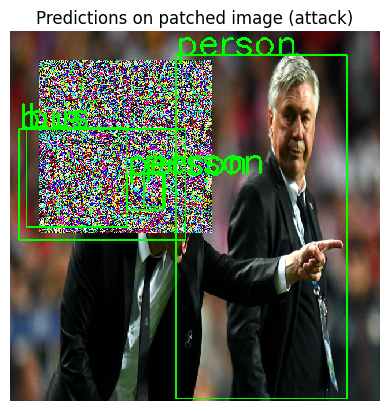

In [15]:
%matplotlib inline
dets = obj_detector.predict(patched_image, standardise_output=True)
threshold = 0.8
preds = extract_predictions_standard(dets[0], threshold)
plot_image_with_boxes_standard(img=patched_image[0].astype(np.uint8), boxes=preds[1], pred_cls=preds[0], title="Predictions on patched image (attack)")

#### Visualize the loss during the attack

In [ ]:
attack = RobustDPatch(
    obj_detector,
    patch_shape=(300,300, 3),
    patch_location=(50, 50),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=1,
    batch_size=1,
    verbose=True,
)

x = image.copy()
y = obj_detector.predict(x=x, standardise_output=False)

history = []
total_history = []
for i in range(50):
    print("Iteration:", i)
    patch = attack.generate(x=x)
    x_patch = attack.apply_patch(x.copy())

    loss = obj_detector.compute_loss(x_patch, y)[0]
    total_history.append(loss)
    print('Total loss:', loss)
    losses = obj_detector.compute_losses(x_patch, y)
    history.append(losses)
    print('Losses:', losses)
    print('------')

#### Plot total loss vs attack iterations

<AxesSubplot: >

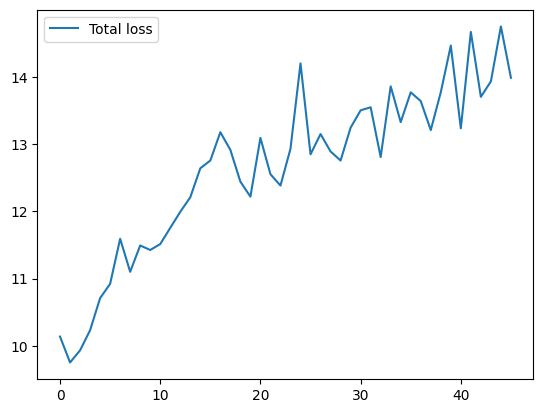

In [23]:
%matplotlib inline
pd.DataFrame(total_history, columns=['Total loss']).plot()